# Example for a Dirichlet distribution

In this example, we are exploring ways to model compositional, or proportional data. For sake of simplicity, we explain our approach using a dataset with 3 components, or "species".

To create a synthetic dataset, we define a model that relates changes in the input, temperature in our case, to changes of the composition, i.e., the outputs.

## Logistic model

In one case, we choose the [Logistic function](https://en.wikipedia.org/wiki/Logistic_function) as our model.

$$
f(x) = \frac{L}{1+e^{-k(x-x_0)}}
$$

with
* $L$ as the carrying capacity, or maximum value to be taken up by $f(x)$,
* $k$ as the growth rate, or the steepnes of the curve, and
* $x_0$ as the displacement along the $x$ axis.

Using three different values for $L$, $k$, and $x_0$, we can define the shape parameter $\alpha$ ($ = f(x) = \frac{L}{1+e^{-k(x-x_0)}}$) of a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution), $\mathcal{Dir}(\alpha)$.

## Macromolecular rate theory (MMRT) model

We could use any other model for $f(x)$, as long as it gives us non-negative values to use as inputs to the shape parameter $\alpha$. We use MMRT, which defined "any" rate that might occur in a biological system (e.g., enzyme reactions, growth rates, etc.). We only make a change to the notation, otherwise this is also just a model of a biological process ($k(T)$ instead of $f(x)$ with free variable $T$):

$$
k(T) = \frac{k_B T}{h}e^{-\frac{\Delta C_p^{\ddagger} (T - T_0) + \Delta H_0^{\ddagger}}{R T} + \frac{\Delta C_p^{\ddagger} \log(T/T_0) + \Delta S_0^{\ddagger}}{R}}
$$

That equation yields four free parameters, $\Delta C_p^{\ddagger}$, $\Delta H_0^{\ddagger}$,  $\Delta S_0^{\ddagger}$, and $T_0$. They define the rate of the considered system. The *macromolecular rate theory* is a thought of as a general law, so a wide range of biological and biochemical cases have been identified where this equations holds.

Our (synthetic) data $Y$ is then drawn from the Dirichlet distribution for a range of values of $x$ ($\in [-10,10]$) which are translated into the shape parameters $\alpha$ from know parameters for the logistic function.

$$
Y \sim \mathcal{Dir}(\alpha) = \mathcal{Dir}(f(x)) 
$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation

import mpltern
from mpltern.datasets import get_triangular_grid

import pandas as pd

import arviz as az
import pymc as pm

from scipy.optimize import curve_fit
import scipy.stats as st

from scipy.constants import Planck, Boltzmann, gas_constant

from tqdm.notebook import tqdm

 True synthetic model parameters: 
kappa = array([1, 1, 1])
dH0 = array([30000, 31000, 32000])
dS0 = array([-110, -105, -100])
dCp = array([ -5000, -10000,  -1000])
T0 = array([260, 270, 270])
(150, 3)
prior_mean = []
prior_sigma = []


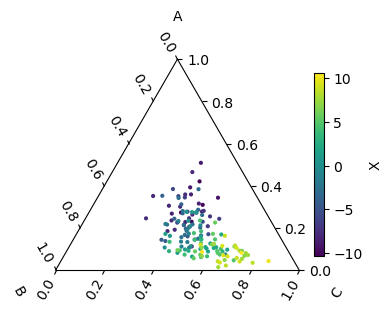

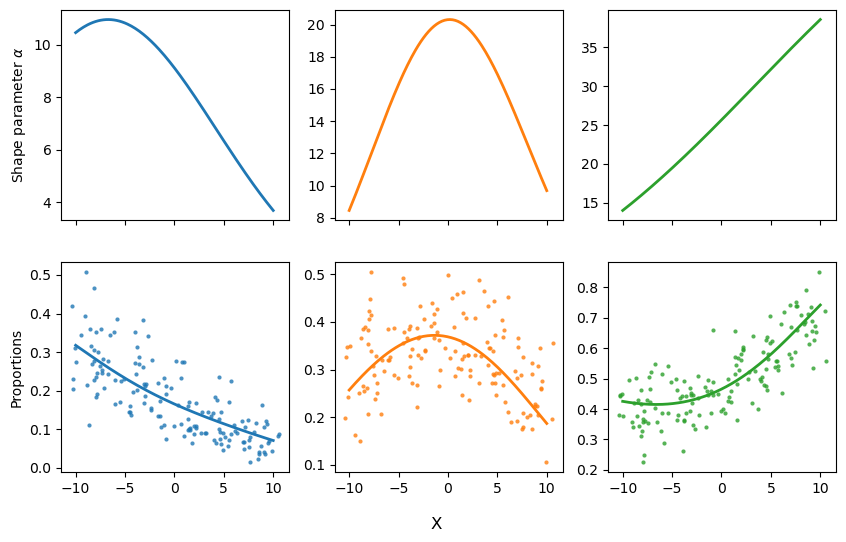

In [2]:
rng = np.random.default_rng()
n_obs = 150
n_obs_test = 50
N = 1

def logistic_curve(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))
    # return L/(1+np.exp(-k*x)*x0)
    
def mmrt(T, kappa, dH0, dS0, T0, dCp):
    return (Boltzmann * (T + 273.15) * kappa / Planck *
            np.exp(-(dH0 + dCp * ((T + 273.15) - T0)) / (gas_constant * (T + 273.15)) +
                   (dS0 + dCp * np.log((T + 273.15)/T0)) / gas_constant))

X_true = np.linspace(-10,10,n_obs)
# rng.shuffle(X_true)
X_true_test = np.sort(rng.uniform(low=-10,high=10,size=n_obs_test)) # this is our test predictor

X_sigma = 1.2
# X0 = np.array([-1,5,25])
X0 = np.array([0.5,0.125,2])
L = np.array([40,10,120])
K = np.array([-0.2,0.1,0.05])

# a great looking random sample
X0 = np.array([-29, 31, -6.4])
# X0 = np.array([0.1, 1.85, 5.00])
L = np.array([ 20,  22, 90])
K = np.array([0.08, 0.02, -0.25])
# print(np.log(X0)/K)

kappa = np.array([1,1,1]) # s^-1 (scaled down)
dH0    = np.array([30_000,31_000,32_000])   # J/mol
dS0   = np.array([-110,-105,-100])  # J/(mol·K)
T0    = np.array([260,270,270])     # K
dCp   = np.array([-5_000,-10_000,-1_000])  # J/(mol·K)


# or random variations of the true parameters
# X_sigma = np.exp(rng.normal(0,0.1))
# # X0 = rng.normal(15,10,size=3)
# X0 = np.exp(rng.normal(size=3))
# L = rng.lognormal(3.5,1.5,size=3)
# K = rng.normal(0,0.2,size=3)

model_type = "mmrt"

if model_type == "logistic":
    s = " True synthetic model parameters: "
    print(s)
    print("".join(["="]*len(s)))
    print(f"{X_sigma = }")
    print(f"{X0 = }")
    print(f"{L = }")
    print(f"{K = }")
    print("".join(["="]*len(s)))
    our_model = logistic_curve
    params = np.array([L,K,X0])
    bounds = ([0,-1,0],[1,1,10])
elif model_type == "mmrt":
    s = " True synthetic model parameters: "
    print(s)
    print("".join(["="]*len(s)))
    print(f"{kappa = }")
    print(f"{dH0 = }")
    print(f"{dS0 = }")
    print(f"{dCp = }")
    print(f"{T0 = }")
    print("".join(["="]*len(s)))
    our_model = mmrt
    params = np.array([kappa, dH0, dS0, T0, dCp])
    bounds = [[0,-50_000,-1000,200,-50_000],[1,50_000,1000,400,50_000]]

# print(f"{np.exp(K*X0) = }")

X = rng.normal(X_true,X_sigma) # this is the predictor we observe

alpha = our_model(X_true[:, None],*params)
# print(alpha)
alpha_test = our_model(X_true_test[:, None],*params)
print(alpha.shape)
A, B, C = np.array([rng.dirichlet(alpha=alpha[i,:]) for i in range(n_obs)]).T # this is our observed Y.
A_test, B_test, C_test = np.array([rng.dirichlet(alpha=alpha_test[i,:]) for i in range(n_obs_test)]).T # this is our observed Y as test.

# Ternary plot of three species
fig, ax = plt.subplots(1,1,figsize=(4,4), subplot_kw={"projection": "ternary"})
pc = ax.scatter(A, B, C, c=X, marker='.',lw=0)
plt.colorbar(pc,ax=ax,shrink=0.5,label='X')
ax.set_tlabel('A')
ax.set_llabel('B')
ax.set_rlabel('C')

fig.tight_layout()
fig.savefig(f"../reports/figures/dirichlet_example_synthetic_data.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

# panel plots of logistic curves
fig, ax = plt.subplots(2,3, figsize=(10,6), sharex=True)
logistic_curves = []
for i in range(3):
    ax[0,i].plot(X_true,our_model(X_true,*[p[i] for p in params]), lw=2, c=f'C{i}')
    logistic_curves.append(our_model(np.sort(X_true),*[p[i] for p in params]))

logistic_curves = np.array(logistic_curves)
logistic_curves /= logistic_curves.sum(axis=0)

prior_mean = []
prior_sigma = []

# fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)
for i,y in enumerate([A,B,C]):
    ax[1,i].plot(X, y, '.', c=f'C{i}', mew=0, alpha=0.8)
    ax[1,i].plot(np.sort(X_true), logistic_curves[i,:], lw=2, c=f'C{i}')

#     popt, pcov = curve_fit(our_model, X , y, bounds=bounds)
#     print(f"{popt = }")
#     prior_mean.append(popt)
#     print(f"{np.sqrt(np.diag(pcov)) = }")
#     prior_sigma.append(np.sqrt(np.diag(pcov)))
#     ax[1,i].plot(np.sort(X), our_model(np.sort(X),*popt), 'k--')

ax[1,0].set_ylabel("Proportions")
ax[0,0].set_ylabel(r"Shape parameter $\alpha$")
fig.supxlabel("X")

print(f"{prior_mean = }")
print(f"{prior_sigma = }")
# print(f"{X0_prior_mean = }")
# print(f"{X0_prior_sigma = }")

# stacked plot
# fig, ax = plt.subplots(1,1, figsize=(10,3))

# sorted_idx = np.argsort(X)
# ax.stackplot(X[sorted_idx],np.array([A,B,C])[:,sorted_idx])
# ax.set_xlabel("X")
# ax.set_ylabel("proportions");

In [3]:
df = pd.DataFrame(data=np.array([A,B,C,X]).T,columns=["A","B","C","X"])
df.index.name = "Sample"
sample_df = df.iloc[rng.choice(n_obs,size=4,replace=False)]
# with pd.option_context('display.float_format', '{:.2f}'.format):
print(np.round(sample_df,2).to_markdown())

|   Sample |    A |    B |    C |     X |
|---------:|-----:|-----:|-----:|------:|
|       88 | 0.13 | 0.34 | 0.53 |  4.52 |
|       31 | 0.2  | 0.31 | 0.49 | -3.82 |
|       59 | 0.28 | 0.34 | 0.38 | -2.3  |
|      137 | 0.07 | 0.26 | 0.67 |  9.47 |


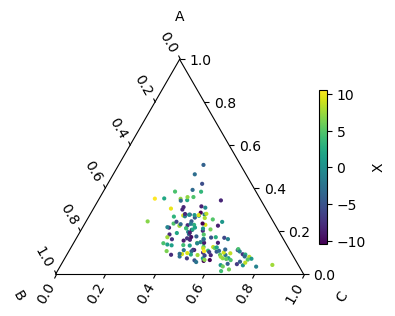

In [4]:
# Ternary plot of three species with shuffled X
fig, ax = plt.subplots(1,1,figsize=(4,4), subplot_kw={"projection": "ternary"})
pc = ax.scatter(A, B, C, c=rng.permutation(X), marker='.',lw=0)
plt.colorbar(pc,ax=ax,shrink=0.5,label='X')
ax.set_tlabel('A')
ax.set_llabel('B')
ax.set_rlabel('C')
fig.savefig(f"../reports/figures/dirichlet_example_synthetic_data_shuffled_X.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

In [5]:
np.round(logistic_curves[:,-1],2)

array([0.07, 0.19, 0.74])

[88] {A, B, C} = 0.13, 0.34, 0.53
[31] {A, B, C} = 0.20, 0.31, 0.49
[59] {A, B, C} = 0.28, 0.34, 0.38
[137] {A, B, C} = 0.07, 0.26, 0.67


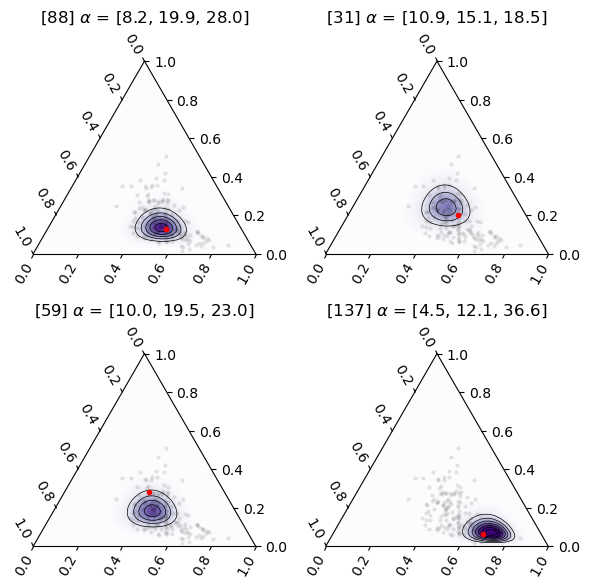

In [6]:
N_GRID = 61
tn0, tn1, tn2 = get_triangular_grid(N_GRID, 1.e-6)

fig, ax = plt.subplots(2,2,figsize=(6,6), subplot_kw={"projection": "ternary"})

# sample_i = np.linspace(0,n_obs-2,4).astype(int)
# print(sample_i)
# sample_alphas = alpha[sample_i,:]

levels = np.arange(0,501,10)

ax = ax.flat
for i,n in enumerate(sample_df.index):

    data = []
    for j in range(tn0.shape[0]):
        data.append(st.dirichlet.pdf([tn0[j],tn1[j],tn2[j]],alpha[n,:]))

    data = np.array(data)
    # print(f"{data.shape = }")
    # print(f"{tn0.shape = }")

    cmap = "Purples"
    shading = "gouraud"
    cs = ax[i].tripcolor(tn0, tn1, tn2, data, vmin=0, vmax=60, cmap=cmap, shading=shading, rasterized=True)
    ax[i].tricontour(tn0, tn1, tn2, data, levels=levels, colors="k", linewidths=0.5)
    ax[i].set_title(f"[{n}] "+r"$\alpha$ = "+f"{list(np.round(alpha[n,:],1))}",fontsize=12)
    ax[i].plot(A, B, C, 'k.', mew=0, alpha=0.1)
    ax[i].plot(A[n],B[n],C[n],'r.')
    print(f"[{n}]"+" {A, B, C} = "+f"{A[n]:.2f}, {B[n]:.2f}, {C[n]:.2f}")
    # ax[i].grid()
    # colorbar = fig.colorbar(cs, cax=cs)
    # plt.colorbar(cs,ax=ax[i],shrink=0.7)
fig.tight_layout()
fig.savefig(f"../reports/figures/dirichlet_example_panel.png",dpi=300,bbox_inches='tight', pad_inches = 0.01)

In [7]:
data = []
for j in range(tn0.shape[0]):
    data.append(st.dirichlet.pdf([tn0[j],tn1[j],tn2[j]],alpha[0,:]))

fig, ax = plt.subplots(1,1, figsize=(4,4), subplot_kw={"projection": "ternary"})

levels = np.arange(0,101,10)
cs = ax.tripcolor(tn0, tn1, tn2, data, vmin=0, vmax=30, cmap=cmap, shading=shading, rasterized=True)
cf = ax.tricontour(tn0, tn1, tn2, data, levels=levels, colors="k", linewidths=0.5)
ax.plot(A, B, C, 'k.', mew=0, alpha=0.1)
l, = ax.plot(A[0], B[0], C[0], 'ro',mec='k')
l_all, = ax.plot(A[0], B[0], C[0], 'k.', mew=0)

def animate(i):
    data = []
    for j in range(tn0.shape[0]):
        data.append(st.dirichlet.pdf([tn0[j],tn1[j],tn2[j]],alpha[i,:]))
    cs.set_array(data)
    # Update the plot objects: remove the previous collections to save memory.
    # global cf, l
    global cf, l, l_all
    cf.remove()
    l.remove()
    l_all.remove()
    cf = ax.tricontour(tn0, tn1, tn2, data, levels=levels, colors="k", linewidths=0.5)
    l_all, = ax.plot(A[:i], B[:i], C[:i], 'k.', mew=0)
    l, = ax.plot(A[i], B[i], C[i], 'ro',mec='k')
    return cs, cf, l, l_all

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=np.arange(n_obs)[::4])

plt.close()
from IPython.display import HTML
HTML(ani.to_html5_video())

In [8]:
FFwriter = matplotlib.animation.FFMpegWriter(fps=5)
ani.save('../reports/figures/dirichlet_example_animation.mp4', writer = FFwriter)

In [9]:
df = pd.DataFrame(data=np.concatenate([np.array([A,B,C]).T,X[:,None]],axis=1),columns=["A","B","C","X"])
df.to_csv(f"../reports/figures/example_dataset_{model_type}.csv",index=None)

In [10]:
N_SAMPLES = 100

combined_indices = np.arange(n_obs)
compound_names = ["A", "B", "C"]

coords = {
    "obs": combined_indices,
    "compound": compound_names,
}

y = np.stack([A,B,C]).T
print(y.shape)

if model_type == "logistic":
    L_mean_prior = np.array([50,10,100])
    with pm.Model(coords=coords) as model:
        # data container
        X_data = pm.Data("X_data", X, dims=("obs"))
        y_data = pm.Data("y_data", y, dims=("obs","compound"))


        # # priors
        # L_mean = 4
        # L_sigma = 1
        # L_mean = pm.Normal("L_mean", mu=3.0, sigma=2)
        # L_sigma = pm.HalfNormal("L_sigma", sigma=1)
        # L_ = pm.LogNormal("L", mu=L_mean, sigma=L_sigma, dims="compound")
        L_sigma = L_mean_prior/5
        # L_ = pm.LogNormal("L", mu=L_mean, sigma=L_sigma, dims="compound")
        L_ = pm.TruncatedNormal("L", mu=L_mean_prior, sigma=L_sigma, lower=0, dims="compound")
        print(f"{L_.eval() = }")

        K_mean = k_prior_mean
        K_sigma = k_prior_sigma
        # K_mean = pm.Normal("K_mean", sigma=1)
        # K_sigma = pm.HalfNormal("K_sigma", sigma=1)
        # K_mean = k_prior_mean
        # K_sigma = k_prior_sigma
        K_ = pm.Normal("K", mu=K_mean, sigma=K_sigma, dims="compound")
        # K_alpha = 0
        # K_beta = 0.02
        # K_ = pm.Cauchy("K", alpha=K_alpha, beta=K_beta, dims="compound")
        print(f"{K_.eval() = }")

        # X0_mean = 13
        # X0_sigma = 10
        # X0_ = 15
        # X0_mean = pm.Normal("X0_mean", mu=0, sigma=2)
        # X0_sigma = pm.HalfNormal("X0_sigma", sigma=1)

        # T_0 as a factor
        # X0_mean = -1
        # X0_sigma = 1
        # X0_ = pm.LogNormal("X0", mu=X0_mean, sigma=X0_sigma, dims="compound")
        # X0_alpha = 3
        # X0_beta = 0.5
        # X0_ = pm.InverseGamma("X0", alpha=X0_alpha, beta=X0_beta, dims="compound")
        # X0_sigma = pm.InverseGamma("X0_sigma", alpha=2, beta=1)
        # X0_mu = pm.Normal("X0_mu", mu=0, sigma=10)
        # X0_sigma = pm.LogNormal("X0_sigma", mu=1, sigma=0.1)
        X0_ = pm.Normal("X0", mu=0, sigma=5, dims="compound")
        # X0_ = pm.Normal("X0", mu=X0_prior_mean, sigma=X0_prior_sigma, dims="compound")

        # X0_ = pm.Uniform("X0", lower=0, upper=5, dims="compound")
        print(f"{X0_.eval() = }")

        # X_sigma_ = pm.InverseGamma("X_sigma", alpha=2, beta=1)
        # X_sigma_ = pm.HalfNormal("X_sigma", sigma=3)
        # print(f"{X_sigma_.eval() = }")

        # X_true_mu_ = pm.Normal("X_mu", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
        # X_true_sigma_ = pm.HalfNormal("X_true_sigma", sigma=1)
        X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))

        X_ = pm.Normal("X", mu=X_true_, sigma=X_sigma, observed=X_data, dims=("obs"))

        # a_ = L_/(1+pm.math.exp(-K_*X_true_[:,None])*X0_)
        a_ = L_/(1+pm.math.exp(-K_*(X_true_[:,None]-X0_)))
        # for i in range(3):
            # a_.append(L_[i]/(1+pm.math.exp(-K_[i]*(X_-X0_[i]))))

        y_ = pm.Dirichlet("y", a=a_, observed=y_data, dims=("obs","compound"))
        print(f"{y_.eval().shape = }")

         # Sample from prior
        trace = pm.sample_prior_predictive(samples=N_SAMPLES)
elif model_type == "mmrt":
    with pm.Model(coords=coords) as model: 
        # data container
        X_data = pm.Data("X_data", X, dims=("obs"))
        y_data = pm.Data("y_data", y, dims=("obs","compound"))
        # prior
        dH0_ = pm.Normal("dH0",mu=30_000, sigma=5_000, dims=("compound"))
        dS0_ = pm.Normal("dS0",mu=-100, sigma=20, dims=("compound"))
        dCp_ = pm.Normal("dCp",mu=-2_000, sigma=1_000, dims=("compound"))
        T0_  = pm.Normal("T0",mu=280, sigma=10, dims=("compound"))
        kappa_ = pm.TruncatedNormal("kappa", mu=1, sigma=1, lower=0, dims=("compound"))
        
        X_true_ = pm.Normal("X_true", mu=np.nanmean(X), sigma=np.nanstd(X), dims=("obs"))
        X_ = pm.Normal("X", mu=X_true_, sigma=X_sigma, observed=X_data, dims=("obs"))
        a_ = (Boltzmann * (X_true_[:,None] + 273.15) * kappa_ / Planck *
            pm.math.exp(-(dH0_ + dCp_ * ((X_true_[:,None] + 273.15) - T0_)) / (gas_constant * (X_true_[:,None] + 273.15)) +
                   (dS0_ + dCp_ * np.log((X_true_[:,None] + 273.15)/T0_)) / gas_constant))
        y_ = pm.Dirichlet("y", a=a_, observed=y_data, dims=("obs","compound"))
        # Sample from prior
        trace = pm.sample_prior_predictive(samples=N_SAMPLES)

(150, 3)


Sampling: [T0, X, X_true, dCp, dH0, dS0, kappa, y]


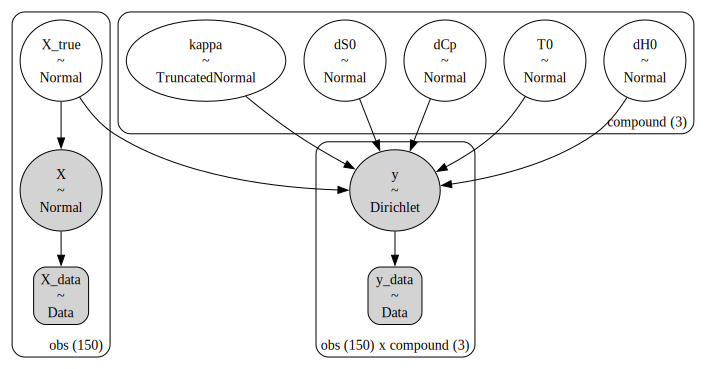

In [11]:
gv = pm.model_to_graphviz(model)
gv

In [12]:
model.free_RVs

[dH0 ~ Normal(3e+04, 5e+03),
 dS0 ~ Normal(-100, 20),
 dCp ~ Normal(-2e+03, 1e+03),
 T0 ~ Normal(280, 10),
 kappa ~ TruncatedNormal(1, 1, 0, inf),
 X_true ~ Normal(-0.0611, 6)]

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/plots/ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/plots/ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


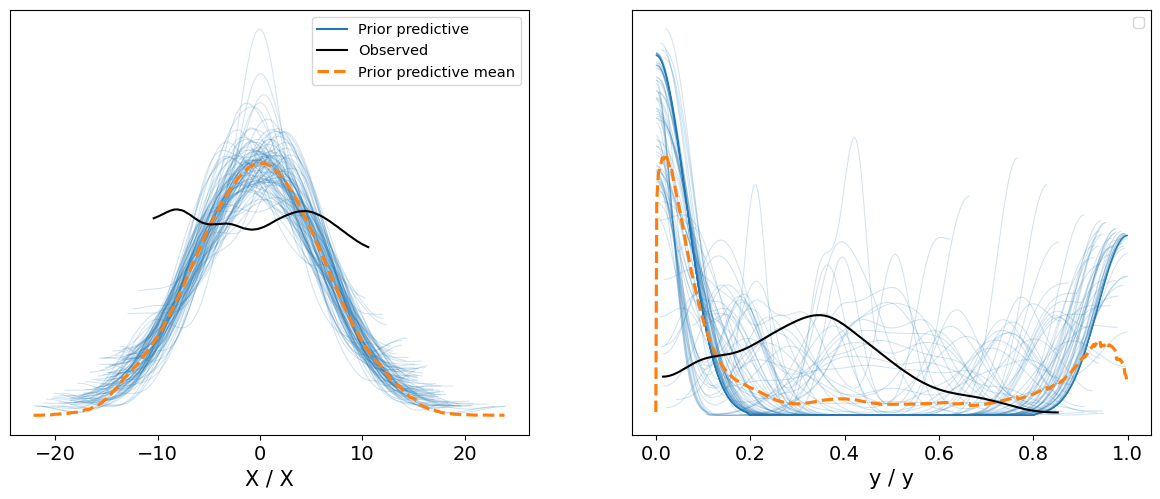

In [13]:
ax = az.plot_ppc(trace, group='prior', observed=True)

  0%|          | 0/100 [00:00<?, ?it/s]

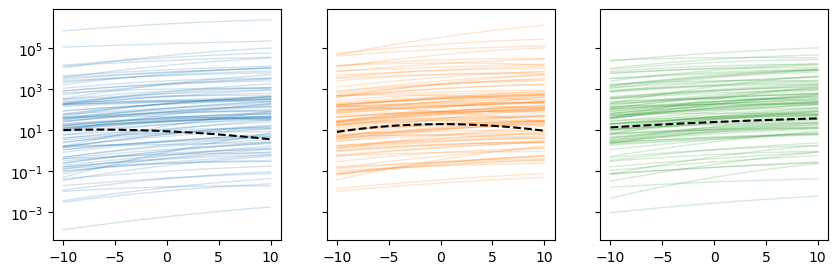

In [14]:
stacked = trace.stack(samples=("chain","draw"))
fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)

for n in tqdm(range(N_SAMPLES)):
    if model_type == "logistic":

        L_p    = stacked.prior["L"].isel(samples=n).values
        # L_p = L
        K_p    = stacked.prior["K"].isel(samples=n).values
        # K_p = K
        X0_p   = stacked.prior["X0"].isel(samples=n).values
        # X0_p = X0
        params_ = np.array([L_p,K_p,X0_p])
    elif model_type == "mmrt":

        kappa_p  = stacked.prior["kappa"].isel(samples=n).values
        dH0_p    = stacked.prior["dH0"].isel(samples=n).values
        dS0_p    = stacked.prior["dS0"].isel(samples=n).values
        dCp_p    = stacked.prior["dCp"].isel(samples=n).values
        T0_p     = stacked.prior["T0"].isel(samples=n).values
        params_p = np.array([kappa_p,dH0_p,dS0_p,T0_p,dCp_p])
    for i in range(3):
        ax[i].plot(X_true,our_model(X_true,*params_p[:,i]), lw=1, alpha=0.2, c=f'C{i}')
        
for i in range(3):
    ax[i].plot(X_true,our_model(X_true,*params[:,i]), 'k--')
    ax[i].set_yscale("log")

In [15]:
if model_type == "logistic":
    var_names = ["L", "X0", "K", "X_sigma"]
elif model_type == "mmrt":
    var_names = ["kappa", "dH0", "dS0", "T0", "dCp"]

var_names = ["~X_true"]

In [16]:
# az.rcParams["plot.max_subplots"] = 200
# az.plot_pair(trace,var_names=var_names,kind='kde',group="prior");

In [17]:
# posterior (or MCMC) sampling
with model:
    trace.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [dH0, dS0, dCp, T0, kappa, X_true]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 306 seconds.


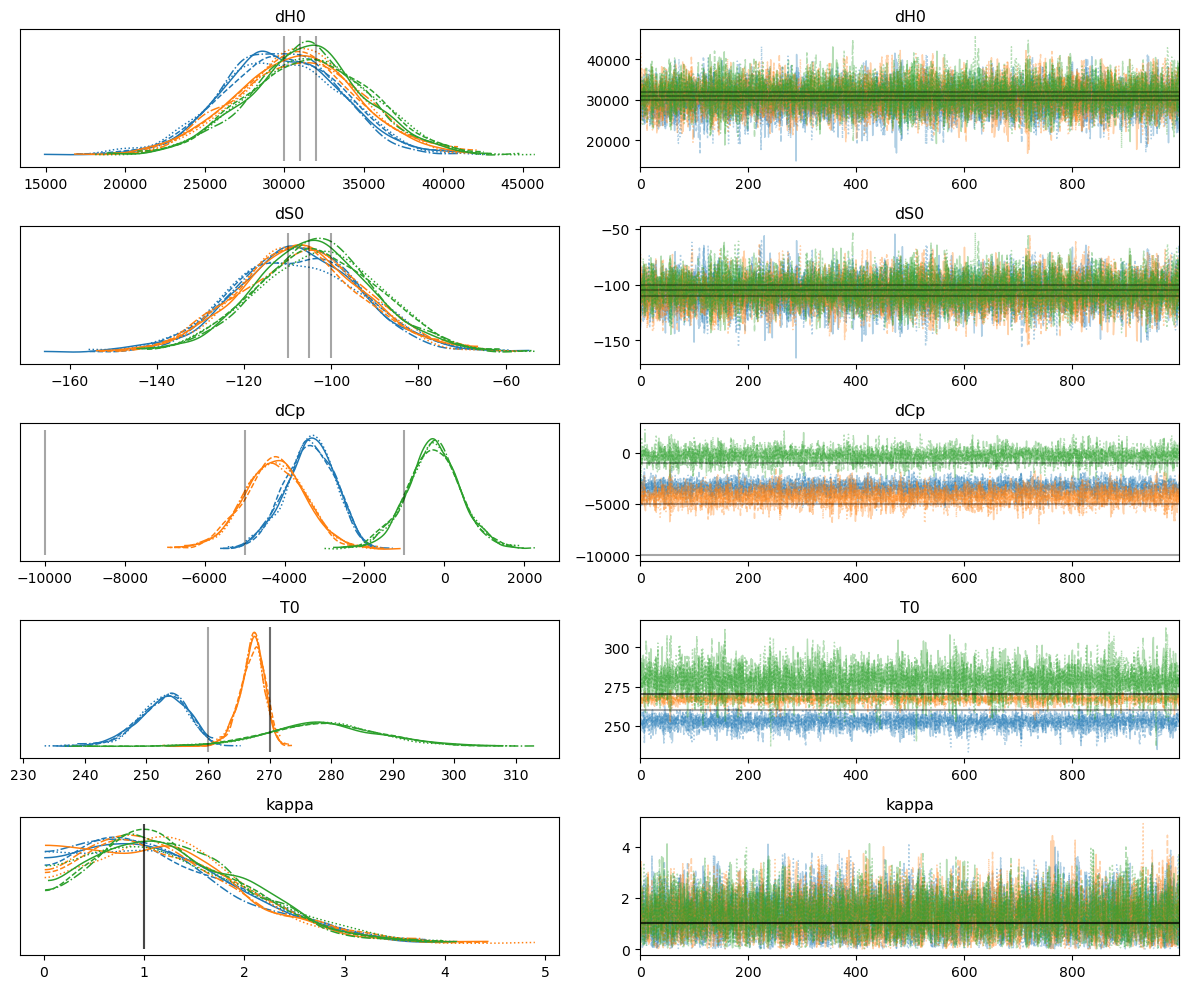

In [18]:
if model_type == "logistic":
    lines = (
        ('L', {}, L),
        ('X0', {}, X0),
        ('K', {}, K),
        # ('X_sigma', {}, X_sigma),
    )
elif model_type == "mmrt":
    lines = (
        ('kappa', {}, kappa),
        ('dH0', {}, dH0),
        ('dS0', {}, dS0),
        ('T0', {}, T0),
        ('dCp', {}, dCp),        
        # ('X_sigma', {}, X_sigma),
    )

ax = az.plot_trace(trace,var_names=var_names, lines=lines)
plt.tight_layout()

In [19]:
az.summary(trace,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dH0[A],29785.501,3698.809,23171.684,36662.665,48.360,34.374,5800.0,2720.0,1.0
dH0[B],30788.039,3810.350,23328.041,37692.975,49.641,35.602,5874.0,2958.0,1.0
dH0[C],31501.699,3764.084,24316.309,38510.101,48.599,35.552,6005.0,2623.0,1.0
dS0[A],-107.715,14.514,-134.599,-80.655,0.180,0.128,6507.0,3061.0,1.0
dS0[B],-106.932,14.184,-134.224,-80.944,0.184,0.130,5979.0,2434.0,1.0
dS0[C],-103.375,13.779,-129.694,-77.740,0.180,0.128,5894.0,2703.0,1.0
dCp[A],-3367.072,620.016,-4518.198,-2219.173,7.844,5.571,6143.0,3166.0,1.0
dCp[B],-4245.685,777.966,-5701.397,-2761.133,9.750,6.895,6409.0,2870.0,1.0
dCp[C],-276.914,687.735,-1665.910,987.962,9.802,8.920,4929.0,3229.0,1.0
T0[A],252.623,4.038,245.330,259.797,0.057,0.040,5441.0,2774.0,1.0


In [20]:
# az.plot_pair(trace,var_names=var_names,kind='kde',divergences=True);

In [21]:
with model:
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [X, y]


Output()

/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/plots/ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/plots/ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


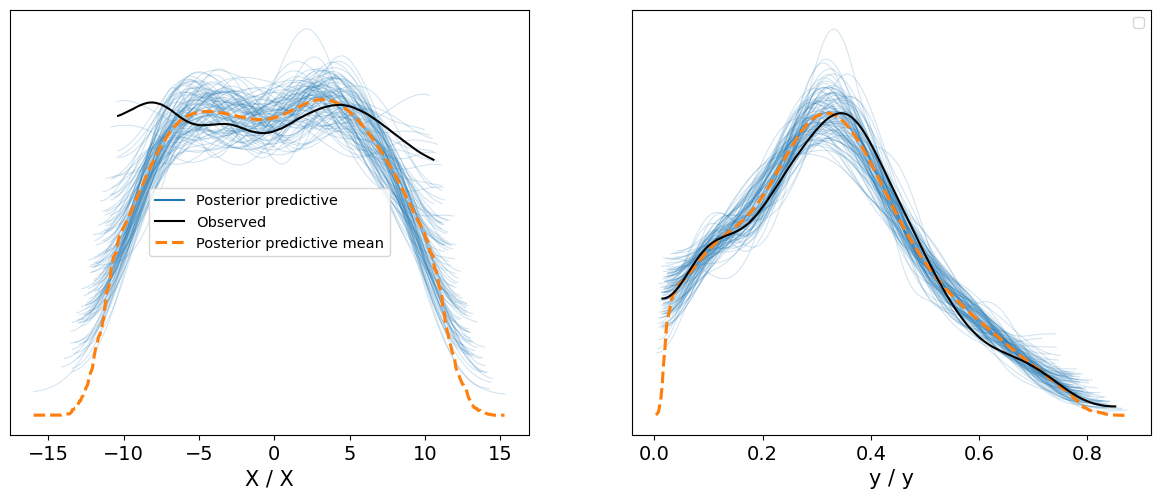

In [22]:
ax = az.plot_ppc(trace, num_pp_samples=100)

Text(0, 0.5, 'estimated X')

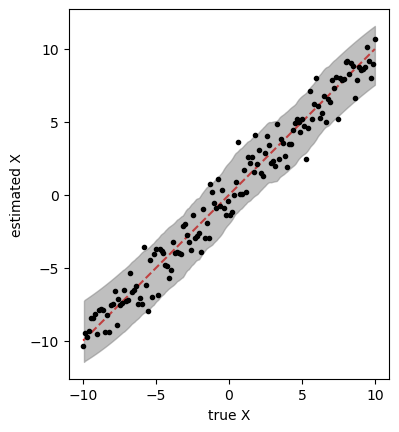

In [23]:
X_true_p = trace.posterior["X_true"].stack(samples=("chain","draw")).mean("samples")

fig, ax = plt.subplots(1,1)
ax.plot(X_true, X_true_p, 'k.')
ax.plot([min(X_true),max(X_true)], [min(X_true),max(X_true)], 'r--', zorder=-5)
az.plot_hdi(X_true, trace.posterior["X_true"],color='gray',ax=ax)
ax.set_aspect("equal")
ax.set_xlabel("true X")
ax.set_ylabel("estimated X")


(150, 3)
(150, 3)


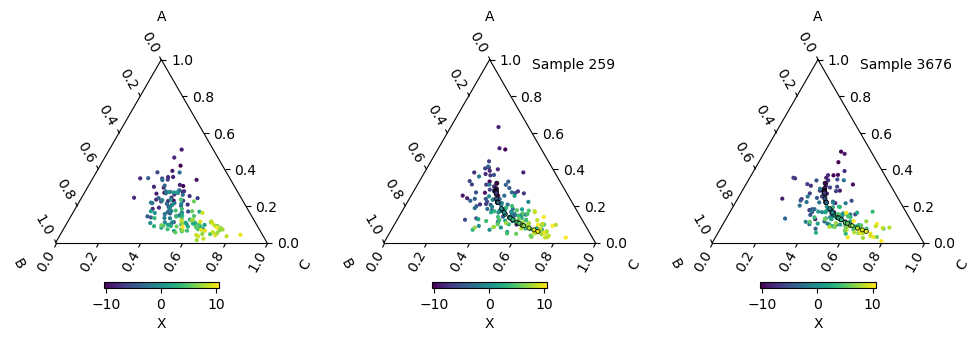

In [24]:
stacked = trace.stack(samples=("chain","draw"))
y_pred_mean = stacked.posterior_predictive["y"].mean("samples")
X_pred_mean = stacked.posterior_predictive["X"].mean("samples")

N_pp = 2
fig, ax = plt.subplots(1,1+N_pp,subplot_kw={"projection": "ternary"},figsize=(10,3.5))

vmin=min(X)
vmax=max(X)
pc = ax[0].scatter(A, B, C, c=X, vmin=vmin, vmax=vmax, marker='.', lw=0)


for i,s in enumerate(rng.choice(len(stacked.posterior_predictive.samples),2)):
    y_pred = stacked.posterior_predictive["y"].isel(samples=s)
    X_pred = stacked.posterior_predictive["X"].isel(samples=s)
    print(y_pred.shape)
    pc = ax[1+i].scatter(y_pred[:,0], y_pred[:,1], y_pred[:,2], c=X_pred, vmin=vmin, vmax=vmax, marker='.',lw=0)
    inc = 5
    ax[1+i].scatter(y_pred_mean[::inc,0], y_pred_mean[::inc,1], y_pred_mean[::inc,2], c=X_pred_mean[::inc], vmin=vmin, vmax=vmax, marker='.',lw=0.5, edgecolors='k')
    ax[1+i].text(0.7,0.95,f"Sample {s}",transform=ax[1+i].transAxes)

for a in ax:
    plt.colorbar(pc,ax=a,orientation="horizontal", shrink=0.5,label='X')
    a.set_tlabel('A')
    a.set_llabel('B')
    a.set_rlabel('C')

fig.tight_layout()

  0%|          | 0/500 [00:00<?, ?it/s]

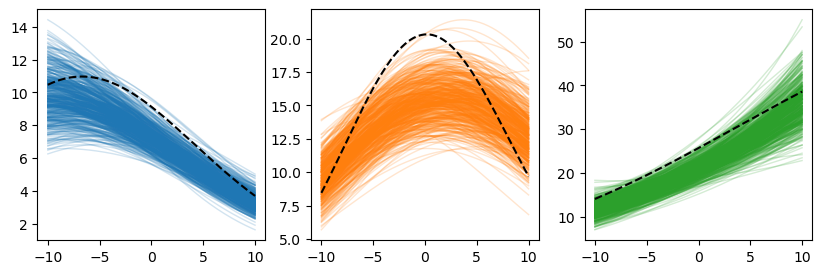

In [25]:
fig, ax = plt.subplots(1,3, figsize=(10,3), sharex=True)

N_TOTAL = 4000#len(stacked.posterior["L"].sel(compound="A"))

for n in tqdm(rng.choice(range(N_TOTAL), size=500)):
    if model_type == "logistic":

        L_p    = stacked.posterior["L"].isel(samples=n).values
        # L_p = L
        K_p    = stacked.posterior["K"].isel(samples=n).values
        # K_p = K
        X0_p   = stacked.posterior["X0"].isel(samples=n).values
        # X0_p = X0
        params_ = np.array([L_p,K_p,X0_p])
    elif model_type == "mmrt":

        kappa_p  = stacked.posterior["kappa"].isel(samples=n).values
        dH0_p    = stacked.posterior["dH0"].isel(samples=n).values
        dS0_p    = stacked.posterior["dS0"].isel(samples=n).values
        dCp_p    = stacked.posterior["dCp"].isel(samples=n).values
        T0_p     = stacked.posterior["T0"].isel(samples=n).values
        params_p = np.array([kappa_p,dH0_p,dS0_p,T0_p,dCp_p])
    for i in range(3):
        ax[i].plot(X_true,our_model(X_true,*params_p[:,i]), lw=1, alpha=0.2, c=f'C{i}')
        
for i in range(3):
    ax[i].plot(X_true,our_model(X_true,*params[:,i]), 'k--')
#     ax[i].set_yscale("log")

In [26]:
with model:
    pm.compute_log_likelihood(trace)

Output()

<Axes: xlabel='X'>

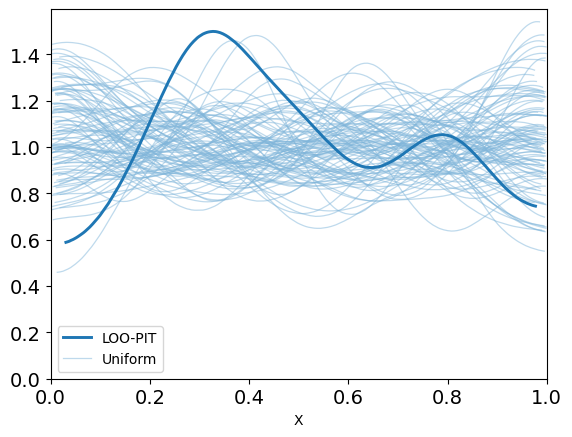

In [27]:
az.plot_loo_pit(trace, "X", ecdf=False)

In [28]:
print(az.loo(trace,var_name='y'))
print(az.loo(trace,var_name='X'))

/var/folders/f6/6cq41zpn3rb9yvws1bb2py85rrskwh/T/ipykernel_41487/2413439397.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(az.loo(trace,var_name='y'))
/var/folders/f6/6cq41zpn3rb9yvws1bb2py85rrskwh/T/ipykernel_41487/2413439397.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(az.loo(trace,var_name='X'))


Computed from 4000 posterior samples and 150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   409.67    10.84
p_loo       22.47        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      147   98.0%
 (0.5, 0.7]   (ok)          3    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Computed from 4000 posterior samples and 150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -332.15     5.20
p_loo      114.78        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        6    4.0%
 (0.5, 0.7]   (ok)         35   23.3%
   (0.7, 1]   (bad)        77   51.3%
   (1, Inf)   (very bad)   32   21.3%



/usr/local/Caskroom/miniforge/base/envs/gdgt/lib/python3.12/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
